<a href="https://colab.research.google.com/github/michaelachmann/social-media-lab/blob/main/2024_12_09_Evaluation_Kurs_V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GPT Evaluation Notebook V3 [![DOI](https://zenodo.org/badge/660157642.svg)](https://zenodo.org/badge/latestdoi/660157642)
![Notes on (Computational) Social Media Research Banner](https://raw.githubusercontent.com/michaelachmann/social-media-lab/main/images/banner.png)

## Overview

This Jupyter notebook is a part of the social-media-lab.net project, which is a work-in-progress textbook on computational social media analysis. The notebook is intended for use in my classes.

The **GPT Evaluation V3** Notebook helps to calculate interrater agreement scores like Cohen's Kappa and Krippendorff's Alpha for a combination of human annotations (exported from [Label Studio](https://labelstud.io/) and GPT- (or other ML/LLM) based annotations. Version two handles multiple JSON files as input, compatible with the open source version of LabelStudio.

### Project Information

- Project Website: [social-media-lab.net](https://social-media-lab.net/)
- GitHub Repository: [https://github.com/michaelachmann/social-media-lab](https://github.com/michaelachmann/social-media-lab)

## License Information

This notebook, along with all other notebooks in the project, is licensed under the following terms:

- License: [GNU General Public License version 3.0 (GPL-3.0)](https://www.gnu.org/licenses/gpl-3.0.de.html)
- License File: [LICENSE.md](https://github.com/michaelachmann/social-media-lab/blob/main/LICENSE.md)


## Citation

If you use or reference this notebook in your work, please cite it appropriately. Here is an example of the citation:

```
Michael Achmann. (2024). michaelachmann/social-media-lab: 2024-12-9 (v0.0.15). Zenodo. https://doi.org/10.5281/zenodo.8199902
```

In [ ]:
# @title Read the LabelStudio Annotations from file
# @markdown <p><b>NEW</b> This version deals with multiple annotation projects. The community version of Label Studio does not handle more than one annotator per item. Setup three different projects using the same data and have one annotator use one project. Export the results and add the files to the list below. The python loop creates one annotation dataset from the three annotations projects and provides all interrater reliability measures as with previous versions of this notebook.<p>
# @markdown <p><b>NEW</b> This version handles `labels` for the annotation of bounding boxes in images.</p>
# @markdown <p><b>NOTE</b> This version does not handle reviews!</p>
# @markdown <hr />

# @markdown Please select the project type. Choose *Single* for a single annotation project, or Multi, to manually join three annotation projects (Label Studio Open Source).
project_type = "Single" # @param ["Multi", "Single"] {allow-input: true}

# @markdown <hr />


single_annotation_project = '/content/drive/MyDrive/2024-01-04-Text-Annotation-Sample.json' # @param {type: "string"}

# @markdown <hr />


annotation_project_1 = '/content/drive/MyDrive/2023-12-22-BA-Pirkl/political-stories-1-annotated.json' # @param {type: "string"}
annotation_project_2 = '/content/drive/MyDrive/2023-12-22-BA-Pirkl/political-stories-2-annotated.json' # @param {type: "string"}
annotation_project_3 = '/content/drive/MyDrive/2023-12-22-BA-Pirkl/political-stories-3-annotated.json' # @param {type: "string"}

if project_type == "Single":
  human_annotations_jsons = [single_annotation_project]
else:
  human_annotations_jsons = [annotation_project_1, annotation_project_2, annotation_project_3]

import json
import pandas as pd
from tqdm.notebook import tqdm

exported_annotations = []

for human_annotations_json in human_annotations_jsons:
  with open(human_annotations_json, 'r') as f:
    j = f.read()
    exported_annotations.append(json.loads(j))



def process_result(result, coder, md):
    value_type = result.get('type', "")
    metadata = {
        **md,
        "coder": coder,
        "from_name": result.get('from_name', "")
    }
    annotations = []
    if value_type == "choices":
        choices = result['value'].get('choices', [])
        for choice in choices:
            r = {**metadata}
            r['value'] = choice
            annotations.append(r)
    elif value_type == "taxonomy":
        taxonomies = result['value'].get('taxonomy', [])
        for taxonomy in taxonomies:
            if len(taxonomy) > 1:
                taxonomy = " > ".join(taxonomy)
            elif len(taxonomy) == 1:
                taxonomy = taxonomy[0]
            r = {**metadata}
            r['value'] = taxonomy
            annotations.append(r)
    elif value_type == "labels":
        labels = result['value'].get('labels', [])
        labels_id = result.get('id', '')
        label = "".join(labels)
        r = {**metadata}
        r['value'] = label
        r['id'] = labels_id
        annotations.append(r)

    return annotations

all_annotations = []
for exported_annotation in tqdm(exported_annotations):
  for data in tqdm(exported_annotation):
      annotations = data.get("annotations")
      metadata = {
          **data.get("data")
      }

      for annotation in annotations:
        coder = annotation['completed_by']
        coder = coder.get('id', coder)

        results = annotation.get("result")
        if results:
          for result in results:
            all_annotations.extend(process_result(result, coder, metadata))
        else:
          print("Skipped Missing Result")


all_annotations_df = pd.DataFrame(all_annotations)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
# Check the dataframe
all_annotations_df.head()

,Text,uuid,Filename,Identifier,coder,from_name,value
0,CDU #SOFORTPROGRAMM MITTELSTANDSPAKET WIR MACH...,3733,cdu/2021-09-13_15-01-28_UTC.jpg,CTxB6cMKe2U,13724,Positioning,True
1,CDU #SOFORTPROGRAMM MITTELSTANDSPAKET WIR MACH...,3733,cdu/2021-09-13_15-01-28_UTC.jpg,CTxB6cMKe2U,13724,Call to Action,False
2,CDU #SOFORTPROGRAMM MITTELSTANDSPAKET WIR MACH...,3733,cdu/2021-09-13_15-01-28_UTC.jpg,CTxB6cMKe2U,13724,Documentation,False
3,CDU #SOFORTPROGRAMM MITTELSTANDSPAKET WIR MACH...,3733,cdu/2021-09-13_15-01-28_UTC.jpg,CTxB6cMKe2U,13724,OCR,False
4,CDU #SOFORTPROGRAMM MITTELSTANDSPAKET WIR MACH...,3733,cdu/2021-09-13_15-01-28_UTC.jpg,CTxB6cMKe2U,7379,Positioning,True


## Contingency Table

We select one coding in this step (e.g. Positioning) and create a contingency table where each annotated item (text, image) occupies one row and each coder one column. The `identifier` should be set to a unique column, like `uuid` or `Filename`.

In [ ]:
# @markdown  Enter the `from_name` for the variable you're interested in at the moment. (Refer to your LabelStudio Interface for the right `from_name`).

import pandas as pd
import numpy as np

from_name = 'Positioning' # @param {type:"string"}
identifier = 'uuid' # @param {type:"string"}

# Assuming your DataFrame is named 'df'
filtered_df = all_annotations_df[all_annotations_df['from_name'].str.contains(from_name, case=False)]

def to_bool(val):
  if isinstance(val, bool):
    return val
  if isinstance(val, str):
    return val.lower() == "true"

  return bool(val)

values = filtered_df['value'].unique()
identifier_values = filtered_df[identifier].unique()

contingency_matrix = pd.crosstab(filtered_df[identifier], filtered_df['coder'], values=filtered_df['value'], aggfunc='first')
contingency_matrix = contingency_matrix.reindex(identifier_values)

In [ ]:
# Let's take a look at the contigency table. We refer to each coder using a pseudonymous number.
contingency_matrix.head()

coder,7107,7379,10506,13724
uuid,,,,
3733,NaN,True,True,True
4185,False,True,True,NaN
530,NaN,True,False,True
2721,NaN,False,False,False
3384,NaN,False,False,False


### Calculate Pairwise $\kappa$

Let's calculate Cohen's Kappa for each coder pair.

In [ ]:
from sklearn.metrics import cohen_kappa_score

# Function to calculate Cohen's Kappa for each pair of raters
def calculate_kappa(matrix):
    raters = matrix.columns
    kappa_scores = []
    for i in range(len(raters)):
        for j in range(i+1, len(raters)):
            rater1, rater2 = raters[i], raters[j]
            # Drop NA values for the pair of raters
            pair_matrix = matrix[[rater1, rater2]].dropna()
            # Skip pairs without overlaps
            if len(pair_matrix) > 0:
              kappa = cohen_kappa_score(pair_matrix[rater1], pair_matrix[rater2])
              kappa_scores.append({
                  "Coder 1": rater1,
                  "Coder 2": rater2,
                  "Kappa": kappa,
                  "Overlap": len(pair_matrix),
                  "Coding": from_name
                  })
    return kappa_scores

kappa_scores = calculate_kappa(contingency_matrix)
kappa_scores_df = pd.DataFrame(kappa_scores)

In [ ]:
# Let's display the pairwise Kappa agreements.
kappa_scores_df

,Coder 1,Coder 2,Kappa,Overlap,Coding
0,7107,7379,0.469027,20,Positioning
1,7107,10506,0.782609,20,Positioning
2,7379,10506,0.669500,50,Positioning
3,7379,13724,0.888889,30,Positioning
4,10506,13724,0.714286,30,Positioning


### Overall Agreement: Krippendorff's $\alpha$

Next, we calculate the overall agreement using Krippendorffs Alpha. First we need to install the package.

In [ ]:
!pip install krippendorff

In [ ]:
import krippendorff
import pandas as pd

def convert_to_reliability_data(matrix):
    transposed_matrix = matrix.T
    reliability_data = []
    for _, ratings in transposed_matrix.iterrows():
        reliability_data.append(ratings.tolist())
    return reliability_data

reliability_data = convert_to_reliability_data(contingency_matrix)

# Calculating Krippendorff's Alpha treating "Unsure" as a distinct category
alpha = krippendorff.alpha(reliability_data=reliability_data, level_of_measurement='nominal')

print("Krippendorff's Alpha:", alpha)

Krippendorff's Alpha: 0.6977687626774848


## Majority Decision

One approach to assess the quality of machine labelled data is the comparison between machine-generated labels and human-generated labels, commonly known as "gold standard" labels. This process is called "label agreement" or "inter-rater agreement" and is widely used in various fields, including natural language processing, machine learning, and computational social science.

We are going to use create a `majority_decision` column using the human annotations: We have chosen an uneven number of annotators in order to find a majority for each label. First, we are going to create a contingency table (or matrix), then we can determine the majority decision.

In [ ]:
import numpy as np
import pandas as pd

# Each row represents an item, and each column a decision from a different annotator.

# Step 1: Find the mode (most common decision) for each row
# The mode is used as it represents the majority decision.
# decisions will have the most frequent value in each row, handling ties by keeping all modes.
decisions = contingency_matrix.mode(axis=1)

# Step 2: Extract the primary mode (first column after mode operation)
# This represents the majority decision. If there's a tie, it takes the first one.
majority_decisions = decisions.iloc[:, 0]

##########
## Warning: This part needs some refactoring. Will be updated shortly.
##########
# Step 3: Count the number of non-NaN values (actual decisions) per row, excluding the first column
# Use .iloc[:, 1:] to exclude the first column
# row_non_nan_counts = contingency_matrix.iloc[:, 1:].notnull().sum(axis=1)

# Step 4: Invalidate the majority decision where the number of decisions is insufficient or even
# Majority decisions are only considered valid if there are more than 2 decisions and the number of decisions is odd.

# Define a condition for invalidating rows
# invalid_rows_condition = (row_non_nan_counts < 3) | (row_non_nan_counts % 2 == 0)


# Step 5: Append the majority decision as a new column in the contingency matrix
# This column now represents the aggregated decision from the annotators per item.
contingency_matrix['Majority Decision'] = majority_decisions

In [ ]:
contingency_matrix.head()

coder,7107,7379,10506,13724,Majority Decision
uuid,,,,,
3733,NaN,True,True,True,True
4185,False,True,True,NaN,True
530,NaN,True,False,True,True
2721,NaN,False,False,False,False
3384,NaN,False,False,False,False


In [ ]:
# @title Import computational annotations
# @markdown Reading the GPT annotations. Enter the correct file path below

import pandas as pd
import numpy as np

annotated_file = '/content/drive/MyDrive/2024-01-04-Text-Annotation-Sample.csv' # @param {type:"string"}
coding_column = 'Positioning' # @param {type:"string"}
annotated_identifier = 'uuid' # @param {type:"string"}

annotated_df = pd.read_csv(annotated_file)

In [ ]:
annotated_df.head()

,Unnamed: 0,Text,Post Type,Positioning,uuid
0,54,Gemeinsam als #eineUnion stehen wir für eine ...,Post,True,54
1,200,Wir wünschen allen Schülerinnen und Schüler...,Post,True,200
2,530,Fränkisches Essen gibt Kraft: Nach einem Mitt...,Post,False,530
3,707,Kleines Zwischenfazit zum #TvTriell.,Post,False,707
4,899,"In einem paar Tagen sind Wahlen, wichtige Wahl...",Story,False,899


In [ ]:
contingency_table = pd.merge(contingency_matrix, annotated_df[['uuid', coding_column]], left_on=identifier, right_on=annotated_identifier, how='left')
contingency_table.rename(columns={coding_column: "Model"}, inplace=True)

In [ ]:
contingency_table.head()

,uuid,7107,7379,10506,13724,Majority Decision,Model
0,3733,NaN,True,True,True,True,True
1,4185,False,True,True,NaN,True,True
2,530,NaN,True,False,True,True,False
3,2721,NaN,False,False,False,False,False
4,3384,NaN,False,False,False,False,False


Let's suppose we're dealing with binary data. We convert all value to binary, in order to be able to compare them correctly.

In [ ]:
# Function to convert a column to boolean if it's not already
def convert_to_bool(column):
    if contingency_table[column].dtype != 'bool':
        bool_map = {'True': True, 'False': False}
        return contingency_table[column].map(bool_map)
    return contingency_table[column]

# Convert columns to boolean if they are not already
contingency_table['Majority Decision']= convert_to_bool('Majority Decision')
contingency_table['Model'] = convert_to_bool('Model')

Let's quickly check pairwise agreement between the Model and Majority Decision using Cohen's Kappa:

In [ ]:
kappa_scores = calculate_kappa(contingency_table[['Majority Decision', 'Model']])
pd.DataFrame(kappa_scores).head()

,Coder 1,Coder 2,Kappa,Overlap,Coding
0,Majority Decision,Model,0.831461,50,Positioning


## Machine Learning Metrics

Finally, let's calculate Accuracy, Precision, and F1 Score and plot a confusion matrix.

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from IPython.display import display, Markdown


# Calculating metrics
accuracy = accuracy_score(contingency_table['Majority Decision'], contingency_table['Model'])
precision = precision_score(contingency_table['Majority Decision'], contingency_table['Model'], average='binary')
recall = recall_score(contingency_table['Majority Decision'], contingency_table['Model'], average='binary')
f1 = f1_score(contingency_table['Majority Decision'], contingency_table['Model'], average='binary')

# Creating a DataFrame for the metrics
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Value': [accuracy, precision, recall, f1]
})

# Displaying the DataFrame as a table
display(metrics_df)

,Metric,Value
0,Accuracy,0.940000
1,Precision,1.000000
2,Recall,0.769231
3,F1 Score,0.869565


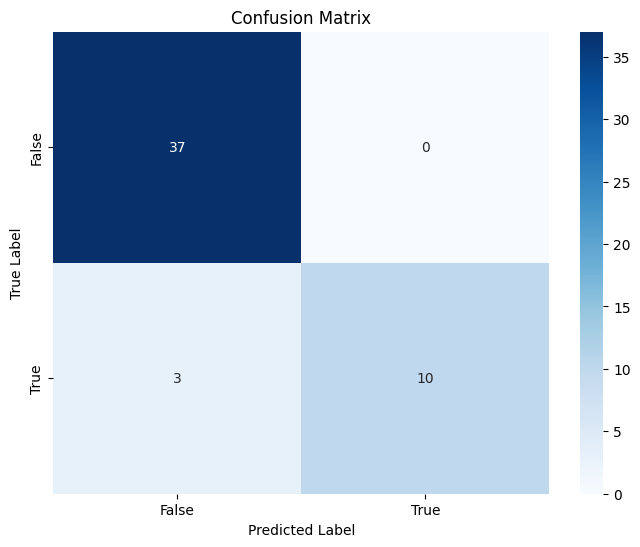

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Generate the confusion matrix
cm = confusion_matrix(contingency_table['Majority Decision'], contingency_table['Model'])

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['False', 'True'], yticklabels=['False', 'True'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()